In [1]:
import tensorflow
print(tensorflow.__version__)

2.9.1


In [2]:
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import *
from keras.layers import *
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import resnet50
from tensorflow.keras import backend

sns.set(style='white', context='notebook', palette='deep')

In [3]:
def add_one_to_one_correlation_line(ax, min_factor=1, max_factor=1, **plot_kwargs):
    lim_min, lim_max = pd.DataFrame([ax.get_ylim(), ax.get_xlim()]).agg({0: 'min', 1: 'max'})
    lim_min *= min_factor
    lim_max *= max_factor
    plot_kwargs_internal = dict(color='grey', ls='--')
    plot_kwargs_internal.update(plot_kwargs)
    ax.plot([lim_min, lim_max], [lim_min, lim_max], **plot_kwargs_internal)
    ax.set_ylim([lim_min, lim_max])
    ax.set_xlim([lim_min, lim_max])

In [4]:
df = pd.read_csv("labels.csv")

In [5]:
df.head()

,id,filename,count
0,0,over_bridge-095_jpg.rf.3d2964d346e6671b2e15319...,90
1,1,Trn-033_jpg.rf.3d5df87711965d9cbb05c06dde476a4...,60
2,2,shadar_ghat-0495_jpg.rf.3d8a331201dcc50fc2ba1c...,34
3,3,bashundhara-221_jpg.rf.3db561b25db66f5dc9993d5...,114
4,4,shadar_ghat-0727_jpg.rf.3d595b4e2c1fc0ee1295f4...,52


In [6]:
# Setup some constants
size = 224
batch_size = 64

In [7]:
# ImageDataGenerator - with defined augmentaions
datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixels to [0,1]. This seems to work well with pretrained models.
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
#     rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
#     zoom_range = 0.2, # Randomly zoom image 
#     width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#     height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False,
    validation_split=0.2,  # 20% of data randomly assigned to validation
    
    # This one is important:
    preprocessing_function=resnet50.preprocess_input,  # Whenever working with a pretrained model, it is said to be essential to use its provided preprocess
)

In [8]:
flow_params = dict(
    dataframe=df,
    directory='./Images/',
    x_col="filename",
    y_col="count",
    weight_col=None,
    target_size=(size, size),
    color_mode='rgb',
    class_mode="raw",
    batch_size=batch_size,
    shuffle=True,
    seed=0,
)

# The dataset is split to training and validation sets at this point
train_generator = datagen.flow_from_dataframe(
    subset='training',
    **flow_params    
)
valid_generator = datagen.flow_from_dataframe(
    subset='validation',
    **flow_params
)

Found 4394 validated image filenames.
Found 1098 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

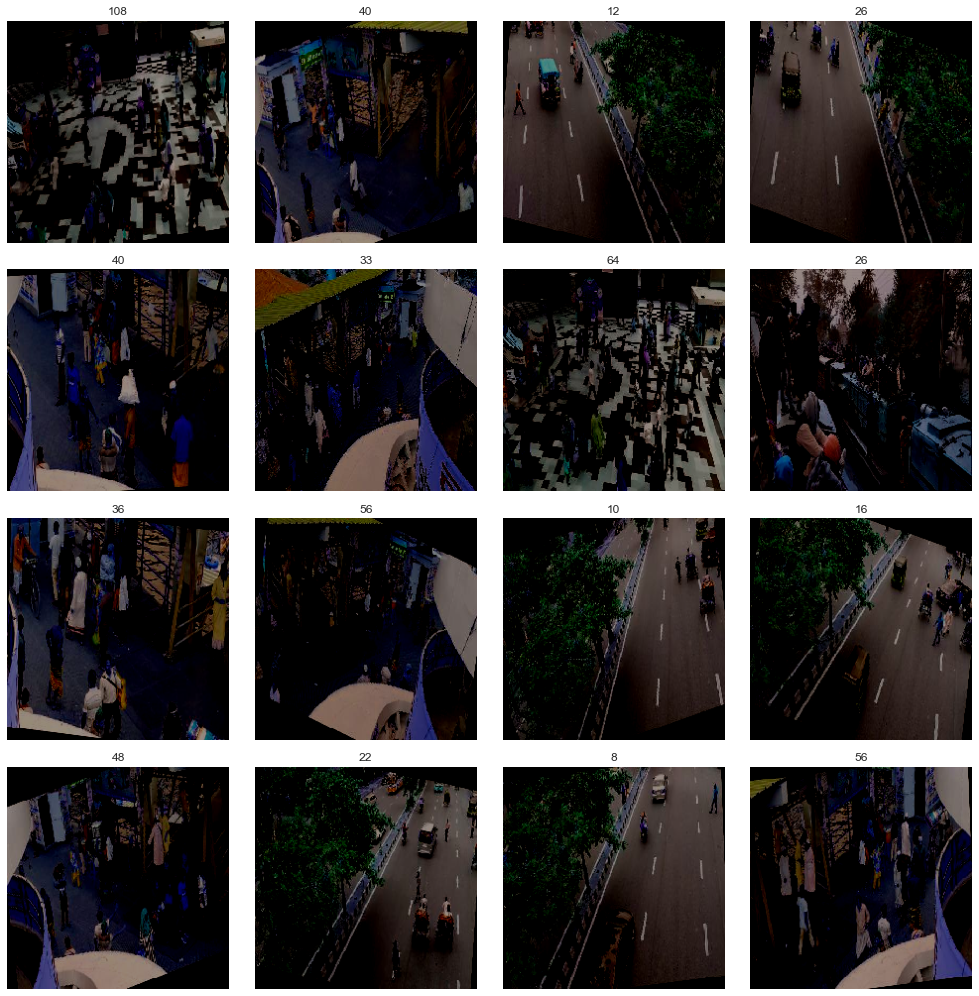

In [9]:
batch = next(train_generator)
fig, axes = plt.subplots(4, 4, figsize=(14, 14))
axes = axes.flatten()
for i in range(16):
    ax = axes[i]
    ax.imshow(batch[0][i])
    ax.axis('off')
    ax.set_title(batch[1][i])
plt.tight_layout()
plt.show()

In [10]:
base_model = resnet50.ResNet50(
    weights='imagenet',  # Load the pretrained weights, trained on the ImageNet dataset.
    include_top=False,  # We don't include the fully-connected layer at the top of the network - we need to modify the top.
    input_shape=(size, size, 3),  # 224x224 was the original size ResNet was trained on, so I decided to use this.
    pooling='avg',  # A global average pooling layer will be added after the last convolutional block.
)

In [11]:
# Here we change the top (the last parts) of the network.
x = base_model.output  # Since we used pooling='avg', the output is of the pooling layer
x = Dense(1024, activation='relu')(x)  # We add a single fully-connected layer
predictions = Dense(1, activation='linear')(x)  # This is the new output layer - notice only 1 output, this will correspond to the number of people in the image

In [12]:
model = Model(inputs=base_model.input, outputs=predictions)

In [13]:
k = -7
for layer in model.layers[:k]:
    layer.trainable = False
print('Trainable:')
for layer in model.layers[k:]:
    print(layer.name)
    layer.trainable = True

Trainable:
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
avg_pool
dense
dense_1


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [15]:
# Define the optimizer - this function will iteratively improve parameters in order to minimise the loss. 
# The Adam optimization algorithm is an extension to stochastic gradient descent, which is usually more effective and fast.
optimizer = Adam(
    # The most important parameter is the learning rate - controls the amount that the weights are updated during eache round of training.
    learning_rate=0.001,
    # Additional parameters to play with:
#     beta_1=0.9,
#     beta_2=0.999,
#     epsilon=1e-07,
)

In [16]:
# Compile the model
model.compile(
    optimizer=optimizer, 
    loss="mean_squared_error",  # This is a classic regression score - the lower the better
    metrics=['mean_absolute_error', 'mean_squared_error']
)

In [17]:
# Set a learning rate annealer - to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function. 
# The LR is decreased dynamically when the score is not improved. This keeps the advantage of the fast computation time with a high LR at the start.
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_mean_squared_error',  # Track the score on the validation set
    patience=3,  # Number of epochs in which no improvement is seen.
    verbose=1, 
    factor=0.2,  # Factor by which the LR is multiplied.
    min_lr=0.000001  # Don't go below this value for LR.
)

In [18]:
# Fit the model
history = model.fit_generator(
    generator=train_generator,
    epochs=100,  # 50 epochs seems to have reached the minimal loss for this setup
    validation_data=valid_generator,
    verbose=2, 
    callbacks=[learning_rate_reduction],
)
print('\nDone.')

Epoch 1/100


C:\Users\Game Lab\AppData\Local\Temp\ipykernel_7788\2868626614.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


69/69 - 23s - loss: 794.0251 - mean_absolute_error: 20.8235 - mean_squared_error: 794.0251 - val_loss: 2207.7983 - val_mean_absolute_error: 43.3113 - val_mean_squared_error: 2207.7983 - lr: 0.0010 - 23s/epoch - 336ms/step
Epoch 2/100
69/69 - 17s - loss: 416.4508 - mean_absolute_error: 15.5961 - mean_squared_error: 416.4508 - val_loss: 690.5626 - val_mean_absolute_error: 20.1771 - val_mean_squared_error: 690.5626 - lr: 0.0010 - 17s/epoch - 253ms/step
Epoch 3/100
69/69 - 18s - loss: 342.7412 - mean_absolute_error: 13.9924 - mean_squared_error: 342.7412 - val_loss: 589.1703 - val_mean_absolute_error: 20.7936 - val_mean_squared_error: 589.1703 - lr: 0.0010 - 18s/epoch - 254ms/step
Epoch 4/100
69/69 - 18s - loss: 290.9042 - mean_absolute_error: 12.8791 - mean_squared_error: 290.9042 - val_loss: 2834.9883 - val_mean_absolute_error: 50.3953 - val_mean_squared_error: 2834.9883 - lr: 0.0010 - 18s/epoch - 255ms/step
Epoch 5/100
69/69 - 18s - loss: 252.7505 - mean_absolute_error: 12.0084 - mean_s

Epoch 35/100
69/69 - 18s - loss: 140.9723 - mean_absolute_error: 8.8694 - mean_squared_error: 140.9723 - val_loss: 161.5809 - val_mean_absolute_error: 9.3667 - val_mean_squared_error: 161.5809 - lr: 1.0000e-06 - 18s/epoch - 255ms/step
Epoch 36/100
69/69 - 18s - loss: 140.0023 - mean_absolute_error: 8.9167 - mean_squared_error: 140.0023 - val_loss: 161.3988 - val_mean_absolute_error: 9.3623 - val_mean_squared_error: 161.3988 - lr: 1.0000e-06 - 18s/epoch - 255ms/step
Epoch 37/100
69/69 - 18s - loss: 139.3577 - mean_absolute_error: 8.8724 - mean_squared_error: 139.3577 - val_loss: 161.3738 - val_mean_absolute_error: 9.3630 - val_mean_squared_error: 161.3738 - lr: 1.0000e-06 - 18s/epoch - 255ms/step
Epoch 38/100
69/69 - 18s - loss: 140.2033 - mean_absolute_error: 8.8927 - mean_squared_error: 140.2033 - val_loss: 161.3419 - val_mean_absolute_error: 9.3613 - val_mean_squared_error: 161.3419 - lr: 1.0000e-06 - 18s/epoch - 256ms/step
Epoch 39/100
69/69 - 18s - loss: 140.4122 - mean_absolute_er

Epoch 70/100
69/69 - 18s - loss: 138.7057 - mean_absolute_error: 8.8474 - mean_squared_error: 138.7057 - val_loss: 160.8657 - val_mean_absolute_error: 9.3500 - val_mean_squared_error: 160.8657 - lr: 1.0000e-06 - 18s/epoch - 255ms/step
Epoch 71/100
69/69 - 18s - loss: 136.5213 - mean_absolute_error: 8.7389 - mean_squared_error: 136.5213 - val_loss: 160.7776 - val_mean_absolute_error: 9.3492 - val_mean_squared_error: 160.7776 - lr: 1.0000e-06 - 18s/epoch - 255ms/step
Epoch 72/100
69/69 - 18s - loss: 138.4003 - mean_absolute_error: 8.8500 - mean_squared_error: 138.4003 - val_loss: 160.7944 - val_mean_absolute_error: 9.3491 - val_mean_squared_error: 160.7944 - lr: 1.0000e-06 - 18s/epoch - 256ms/step
Epoch 73/100
69/69 - 18s - loss: 139.2812 - mean_absolute_error: 8.8676 - mean_squared_error: 139.2812 - val_loss: 160.8449 - val_mean_absolute_error: 9.3487 - val_mean_squared_error: 160.8449 - lr: 1.0000e-06 - 18s/epoch - 256ms/step
Epoch 74/100
69/69 - 18s - loss: 137.7172 - mean_absolute_er

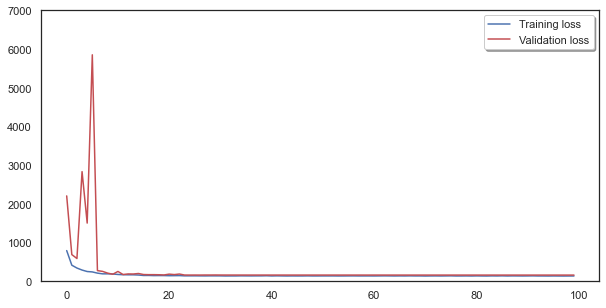

In [19]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(history.history['loss'], color='b', label="Training loss")
ax.plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax)
ax.set_ylim(top=np.max(history.history['val_loss'])*1.2, bottom=0)
legend = ax.legend(loc='best', shadow=True)

In [20]:
# Predict on entire validation set, to be able to review the predictions manually
valid_generator.reset()
all_labels = []
all_pred = []
for i in range(len(valid_generator)):
    x = next(valid_generator)
    pred_i = model.predict(x[0])[:,0]
    labels_i = x[1]
    all_labels.append(labels_i)
    all_pred.append(pred_i)
#     print(np.shape(pred_i), np.shape(labels_i))

cat_labels = np.concatenate(all_labels)
cat_pred = np.concatenate(all_pred)

1/1 [==============================] - 1s 640ms/step


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


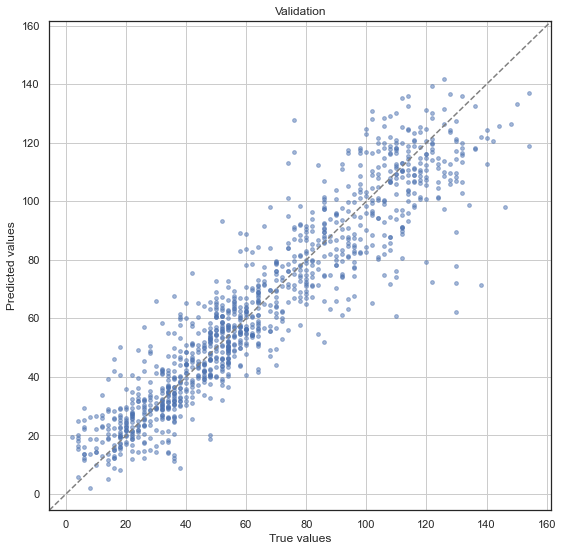

In [21]:
df_predictions = pd.DataFrame({'True values': cat_labels, 'Predicted values': cat_pred})
ax = df_predictions.plot.scatter('True values', 'Predicted values', alpha=0.5, s=14, figsize=(9,9))
ax.grid(axis='both')
add_one_to_one_correlation_line(ax)
ax.set_title('Validation')

plt.show()

In [22]:
mse = mean_squared_error(*df_predictions.T.values)
pearson_r = sc.stats.pearsonr(*df_predictions.T.values)[0]

print(f'MSE: {mse:.1f}\nPearson r: {pearson_r:.1f}')

MSE: 160.6
Pearson r: 0.9


In [23]:
model.save('SaveModel/model')

INFO:tensorflow:Assets written to: SaveModel/model\assets


INFO:tensorflow:Assets written to: SaveModel/model\assets


In [24]:
model.save_weights('checkpoints/my_checkpoint')


2/2 [==============================] - 0s 85ms/step


2/2 [==============================] - 0s 96ms/step


2/2 [==============================] - 0s 84ms/step


2/2 [==============================] - 0s 97ms/step


2/2 [==============================] - 0s 98ms/step


2/2 [==============================] - 0s 99ms/step


2/2 [==============================] - 0s 99ms/step


2/2 [==============================] - 0s 90ms/step


2/2 [==============================] - 0s 90ms/step


2/2 [==============================] - 0s 86ms/step


2/2 [==============================] - 0s 96ms/step


2/2 [==============================] - 0s 82ms/step


2/2 [==============================] - 0s 96ms/step


2/2 [==============================] - 0s 106ms/step


2/2 [==============================] - 0s 90ms/step


2/2 [==============================] - 0s 102ms/step


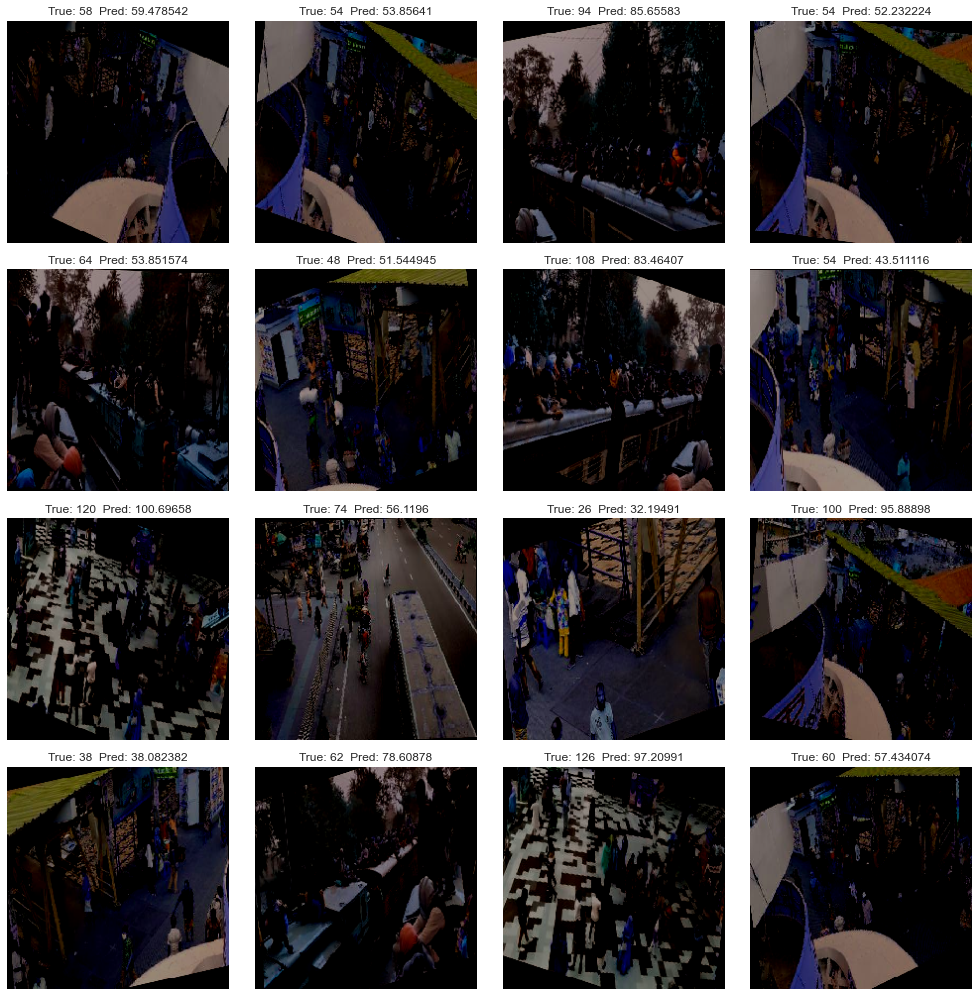

In [29]:
valid_generator.reset()
batch = next(valid_generator)
fig, axes = plt.subplots(4, 4, figsize=(14, 14))
axes = axes.flatten()
for i in range(16):
    ax = axes[i]
    ax.imshow(batch[0][i])
    ax.axis('off')
    p = model.predict(batch[0])[:,0]
    p = p[i]
    st = 'True: '+ str(batch[1][i]) + '  Pred: ' + str(p)
    ax.set_title(st)
plt.tight_layout()
plt.show()